In [1]:
# https://docs.lightkurve.org/tutorials/3-science-examples/other-supernova-lightcurve.html

# How to make a supernova lightcurve?

You can use `lightkurve` to extract a lightcurve of transient phenomena, including supernovae. Supernovae data analysis presents a few unique challenges compared to data analysis of isolated point sources.  We can anticipate some of the common limitations of the Kepler pipeline-processed lightcurves, which make no attempt to hone-in on supernovae.  For example, the supernova resides in a host galaxy which may itself be time variable due to, *e.g.*, active galactic nuclei (AGN).  Common detrending methods, such as "Self Flat Fielding" ([SFF](https://archive.stsci.edu/prepds/k2sff/)) assume that centroid shifts are due entirely to undesired motion of the spacecraft, while transients induce bona-fide astrophysical centroid motion as the postage-stamp photocenter gets weighted towards the increasingly luminous transient's photocenter. 

In this tutorial we will custom-make a custom supernova lightcurve with these simple steps:

1. Create an appropriate aperture mask to isolate the transient from its host galaxy
2. Extract aperture photometry of both the supernova and the background attributable to the host galaxy  
3. Apply "Self Flat Fielding" (SFF) detrending techniques  
4. Plot the lightcurve

We will focus on an unusual class of transient recently observed in K2, the so-called *Fast-Evolving Luminous Transients* or **FELT**s.  These transients rise and fall within a mere few days, much shorter than conventional supernovae, which can last hundreds of days.  The discovery of **KSN2015k** was recently reported by [Rest et al. 2018](https://www.nature.com/articles/s41550-018-0423-2) and summarized in at least two press releases from [STSci](http://hubblesite.org/news_release/news/2018-18) and [JPL](https://www.jpl.nasa.gov/news/news.php?feature=7086).

The EPIC ID for `KSN2015k`'s host galaxy is **212593538**.  

In [2]:
%matplotlib inline
import numpy as np
from lightkurve import search_targetpixelfile
tpf = search_targetpixelfile('EPIC 212593538', author="K2", campaign=6).download()
tpf.shape

(3545, 8, 8)

The TPF has 3545 useable cadences, with an $8 \times 8$ postage stamp image.

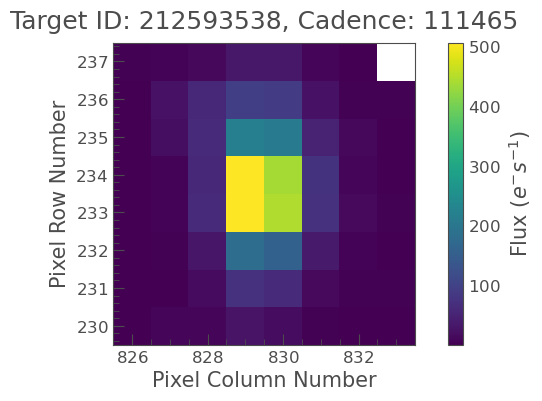

In [3]:
tpf.plot(frame=100);

The coarse angular resolution of Kepler means that this host galaxy resembles a pixelated blob.  We're showing frame 100 out of 3561 frames-- we do not presently know when the supernova went off so it's hard to say whether there is a supernova in the image or not.

One of the pixels is white, which represents `NaN` values in the color image.  In fact, this pixel within the $8 \times 8$ square postage stamp image boundary is `NaN` in all 3561 cadences, indicating that this TPF has an irregular boundary with $N_{\rm pix} = 63$.  Irregular boundaries are a common space-saving strategy for the distant Kepler telescope.

In [4]:
postage_stamp_mask = tpf.hdu[2].data > 0
postage_stamp_mask.sum()

63

Let's make a lightcurve summing *all of the pixels* to see if we can pick out the FELT *by-eye*.  We will pre-process the lightcurve to remove sharp discontinuities in the time series that arise from spurious cosmic rays, not our astrophysical transient of interest.

In [5]:
lc_raw = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
lc_clean = lc_raw[~spurious_cadences]

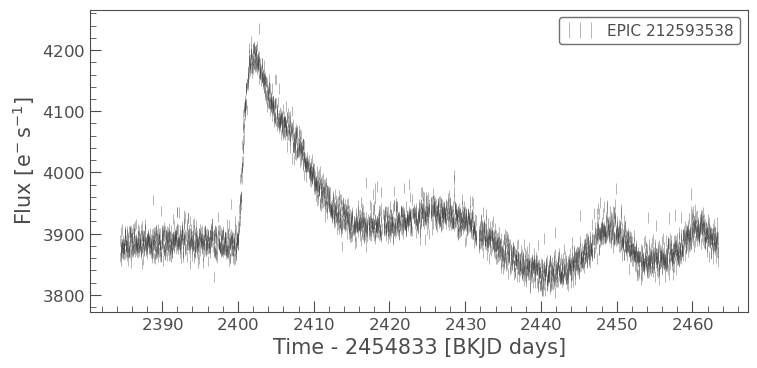

In [6]:
lc_clean.errorbar(alpha=0.5, normalize=False);

**Voilà**!  We indeed see what looks like a sharply-rising phenomenon at $t = 2400-2415$ days, distinct from the smoothly-varying background, which could arise from either instrumental artifacts or host-galaxy.  

Let's identify where the FELT was located within the host galaxy and its K2 postage stamp.  We can either visually inspect the lightcurve with [interact](http://lightkurve.keplerscience.org/tutorials/1.05-interact-with-lightcurves-and-tpf.html) to look for the position of the explosion, or we can programmatically select cadences to estimate a difference image.   I used [interact()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.interact.html?highlight=interact#lightkurve.KeplerTargetPixelFile.interact) with a fine-tuned screen-stretch to see that the FELT appears near pixel column 830, row 231.  Furthermore, it looks like the flux drops off significantly in the first and last columns.

In [7]:
#tpf.interact(lc=lc_clean)

Once we have our aperture and background masks, we can estimate the net flux $f_{\rm net}$ as:

$f_{\rm net}(t) = f_{\rm aper}(t) - f_{\rm b}(t) \cdot N_{\rm aper}$

where $f_{\rm aper}$ is the total summed flux in an aperture of size $N_{\rm aper}$ pixels, and $f_{b}$ is our estimate for the (spatially-flat) background level per pixel, in each cadence.

In [8]:
aperture_mask = postage_stamp_mask.copy()
aperture_mask[:,-1] = False
aperture_mask[:,0] = False
background_mask = ~aperture_mask & postage_stamp_mask

In [9]:
N_targ_pixels, N_back_pixels = aperture_mask.sum(), background_mask.sum()
N_targ_pixels, N_back_pixels

(48, 15)

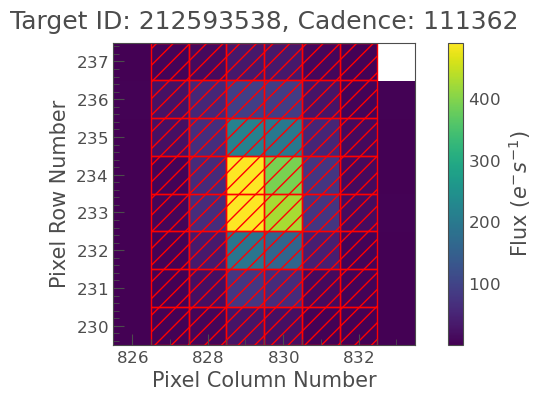

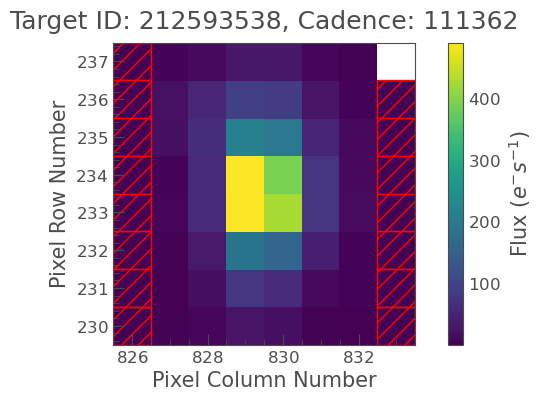

In [10]:
tpf.plot(aperture_mask=aperture_mask);
tpf.plot(aperture_mask=background_mask);

Checks out.  Let's apply the equation above:

In [11]:
lc_aper = tpf.to_lightcurve(aperture_mask=aperture_mask) 
lc_back_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / N_back_pixels

In [12]:
lc_net = lc_aper - lc_back_per_pixel.flux * N_targ_pixels

Drop the previously-identified spurious cadences.

In [13]:
lc_net = lc_net[~spurious_cadences]

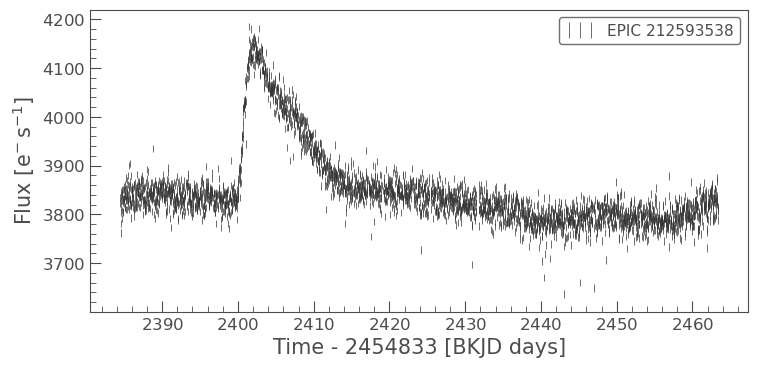

In [14]:
lc_net.errorbar();

Much better!  We no longer see the instrumentally-induced background wiggles.